In [1]:
from tdc.multi_pred import DTI
import numpy as np
from rdkit.Chem import AllChem
from rdkit import Chem

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import math
from sklearn.metrics import silhouette_score

data = DTI(name = 'BindingDB_Kd')
# data = DTI(name = 'DAVIS')
# data = DTI(name = 'KIBA')

Found local copy...
Loading...
Done!


In [2]:
def drugTarget2vec(data):
    data = data.get_data()
    
    data_selected = data[['Drug_ID','Drug','Target_ID','Target','Y']] 
    data_selected['Drug2vector'] = ''
    data_selected['TargetId'] = ''
    
    # use rdkit calculate ECFPs
    for ind, drug in enumerate(data_selected['Drug']):
        mol = Chem.MolFromSmiles(drug)
        Morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2) 
        #Explicitbitvects, which record whether or not a bit exists, are usually faster than SparseBitVects, but take up more memory, similar to fixed-length bit strings.
        intmap = map(int, Morgan_fp.ToBitString())
        data_selected['Drug2vector'][ind] = np.array(list(intmap))
    
    # create a dict to record the map relation of Target and TargetID
    ID_to_Target = dict(enumerate(list(dict.fromkeys(data_selected['Target']))))
    Target_to_ID = {value:key for key,value in ID_to_Target.items()} 
    
    # build the target2ID columns into dataframe 
    for ind, target in enumerate(data_selected['Target']):
        data_selected['TargetId'][ind] = np.array(Target_to_ID[target])   
    
    return data_selected

# the new df with Drug2Vector and Target2Id
data_transformed = drugTarget2vec(data)

In [3]:
# select the new columns
data_selected = data_transformed[['Drug2vector','Drug','Target_ID','Target','Y']]

In [4]:
data_selected

,Drug2vector,Drug,Target_ID,Target,Y
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.460
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.490
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.830
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.200
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.160
...,...,...,...,...,...
52269,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.150
52270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2CC[C@H](O)...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,2.700
52271,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.045
52272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,17.000


In [5]:
from torch.utils.data import DataLoader
drug_vector = data_selected['Drug2vector']
train_loader = DataLoader(dataset=drug_vector, shuffle=False, batch_size=len(data_selected))
sample = next(iter(train_loader))
sample = np.array(sample) # get the array like Drug2Vector
print(sample)
print(sample.shape) # show the shape of Drug2vector

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(52274, 2048)


In [6]:
# use function to get the Vovariance matrix 
cov_mat = np.cov(sample.T)

# from Covariance matrix get Eigenvalues and EigenVectors
# Eigenvalues show the importance of EigenVectors
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
# the ith column in the eig_vecs maps the ith Eigenvalues in eig_vals 

Eigenvectors 
[[-0.00014768  0.00014329 -0.00018361 ... -0.00053015 -0.00381488
  -0.00274119]
 [-0.01827565  0.03807093 -0.05332529 ...  0.00231449  0.003521
  -0.00309096]
 [ 0.00449323 -0.00500181  0.0068359  ... -0.00311126  0.00785605
   0.00349815]
 ...
 [ 0.00197307  0.00314962  0.01008954 ...  0.04393862  0.00126644
  -0.00575878]
 [-0.00036673  0.00034497 -0.00053029 ...  0.02669059  0.04260528
  -0.03526622]
 [ 0.00893484 -0.00801218 -0.01551026 ... -0.0002107  -0.01060018
  -0.00642222]]

Eigenvalues 
[2.44447943e+00 1.77054648e+00 1.25139890e+00 ... 4.10458425e-04
 3.87845464e-04 3.90149543e-04]


In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order(Top 20):')
for i,Eigenvalues in enumerate(eig_pairs):
    if i>20:
        break
    print(Eigenvalues[0])

Eigenvalues in descending order(Top 20):
2.4444794251347286
1.770546478917295
1.2513989007622337
1.2024624834239201
1.1613047269955161
1.0967771491119864
1.0306802339678225
0.8471137390570601
0.8114882986351003
0.73264774115887
0.7032625954361841
0.6793144584242276
0.6462289592434179
0.6318891353535746
0.5967149570210745
0.5817016143865866
0.5480569559794193
0.5425277875041824
0.5204344791368335
0.5047382037745913
0.4979810447223743


In [8]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)] # the percentage of each values
cum_var_exp = np.cumsum(var_exp) # calculate the percentage of first n values (for draw the line)

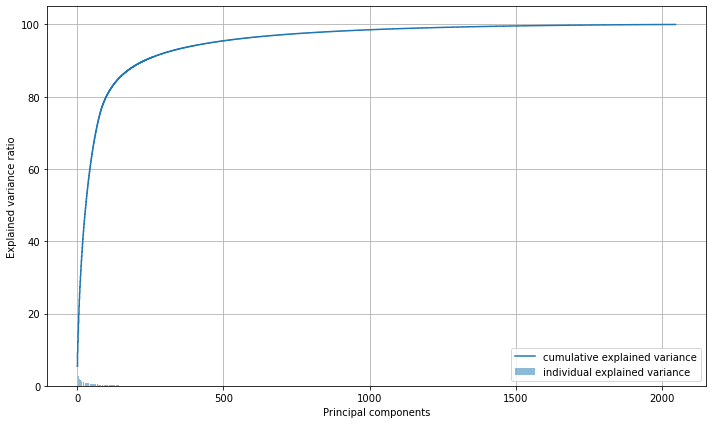

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(cum_var_exp)), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(which = 'both')
plt.show()
# the figure show the top 150 eigenvalues are most important

In [10]:
# use PCA to reduce the dimension to 150
pca = PCA(n_components=150)

In [11]:
%%time
# try to find the best number of cluster
cluster_num_list = [i*10 for i in range(1,15)]
the_processed_data = data_selected 
the_processed_data = the_processed_data.Drug2vector.tolist()
the_processed_data = pca.fit_transform(the_processed_data, y=None)
kmeans_per_k = [KMeans(n_clusters = k).fit(the_processed_data) for k in cluster_num_list]

inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(the_processed_data,model.labels_) for model in kmeans_per_k]

Wall time: 11min 47s


Text(0, 0.5, 'Silhouette score')

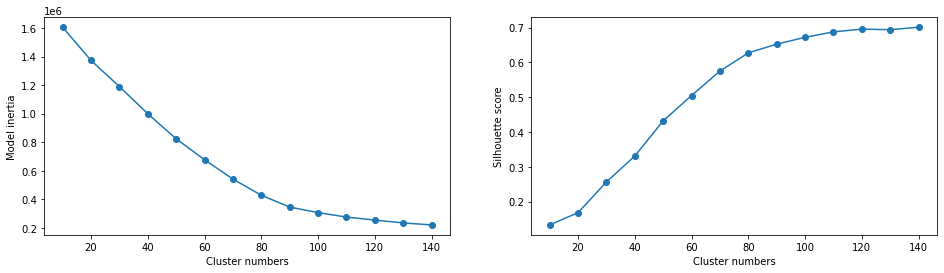

In [12]:
plt.figure(figsize=(16,4))

# plot the inertia
plt.subplot(121)
plt.plot(cluster_num_list,inertias,'o-')
plt.xlabel("Cluster numbers")
plt.ylabel("Model inertia")

# plot the Silhouette score
plt.subplot(122)
plt.plot(cluster_num_list,silhouette_scores,'o-')
plt.xlabel("Cluster numbers")
plt.ylabel("Silhouette score")

In [13]:
# input data: dataFrame with drug2Vec 
# return a dataFrame with labels of cluster
def kMeansCluster(data,n_clusters = 100,n_components = 150):
    # pca to 150
    temp_data = data 
    temp_data = temp_data.Drug2vector.tolist()
    pca = PCA(n_components)
    temp_data = pca.fit_transform(temp_data, y=None)
    # the kmeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(temp_data)
    data['labels'] = labels
    return data

In [14]:
%%time
data_kmeans = kMeansCluster(data_selected)
data_kmeans

Wall time: 34.9 s


,Drug2vector,Drug,Target_ID,Target,Y,labels
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.460,94
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.490,94
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.830,94
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.200,94
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.160,1
...,...,...,...,...,...,...
52269,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.150,1
52270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2CC[C@H](O)...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,2.700,96
52271,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.045,69
52272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,17.000,97


In [15]:
print("The number of clusters in kmeans model: ",max(data_kmeans.labels)+1)

The number of clusters in kmeans model:  100


In [16]:
%%time
# try to find the best number of cluster
eps_list = [i for i in [1,1.5,2,2.5,3,3.5,4,4.5,5]]
the_processed_data = data_selected 
the_processed_data = the_processed_data.Drug2vector.tolist()
the_processed_data = pca.fit_transform(the_processed_data, y=None)
dbscan_per_eps = [DBSCAN(eps=eps, min_samples=30).fit(the_processed_data) for eps in eps_list]

silhouette_scores = [silhouette_score(the_processed_data,model.labels_) for model in dbscan_per_eps]

Wall time: 53min 35s


Text(0, 0.5, 'Silhouette score')

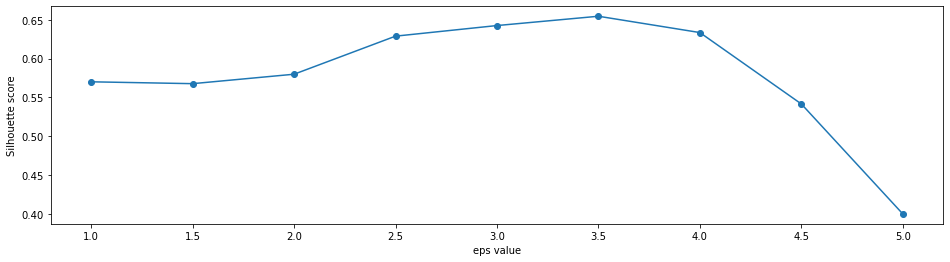

In [17]:
plt.figure(figsize=(16,4))
plt.plot(eps_list,silhouette_scores,'o-')
plt.xlabel("eps value")
plt.ylabel("Silhouette score")

In [18]:
def DBSCAN_Cluster(data,eps=3.5,min_samples=30,n_components = 150):
    # pca to 150
    temp_data = data 
    temp_data = temp_data.Drug2vector.tolist()
    pca = PCA(n_components)
    temp_data = pca.fit_transform(temp_data, y=None)
    # the DBSCAN model
    DBSCAN_model= DBSCAN(eps=eps, min_samples=min_samples)
    labels = DBSCAN_model.fit_predict(temp_data)
    data['labels'] = labels
    return data

In [19]:
%%time
data_DBSCAN = DBSCAN_Cluster(data_selected)
data_DBSCAN

Wall time: 6min 43s


,Drug2vector,Drug,Target_ID,Target,Y,labels
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.460,0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.490,0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.830,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.200,0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.160,0
...,...,...,...,...,...,...
52269,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.150,-1
52270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2CC[C@H](O)...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,2.700,-1
52271,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,NaN,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,0.045,-1
52272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",CCCCCCCOC1OC(CO)C(O)C(O)C1O,P08191,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,17.000,0


In [20]:
print("The number of clusters in DBSCAN model: ",max(data_DBSCAN.labels)+1)

The number of clusters in DBSCAN model:  131


In [21]:
def get_split(method='kmeans', seed=42, frac=[0.7, 0.1, 0.2], column_name=None):
    
    if method == 'kmeans':
        data = kMeansCluster(data_selected) 
        
    elif method == 'dbscan':
        data = DBSCAN_Cluster(data_selected) 
    
    # get the number of cluster 
    num_cluster = max(data.labels)+1 
  
    len_train = int(num_cluster * frac[0]) # the lenght of train,val and test
    len_val = int(num_cluster * frac[1])
    
    train_label = range(0,len_train) 
    val_label = range(len_train, len_val) 
    test_label = range(len_val,num_cluster) 
    
    train_set = data[data.labels<=len_train] # the data in train set
    val_set = data[(len_train<data.labels)&(data.labels<=(len_train+len_val))] # the data in val set
    test_set = data[data.labels>(len_train+len_val)] # the data in test set

    return train_set, val_set, test_set 

In [22]:
train,val,test = get_split(method='kmeans', seed=42, frac=[0.7, 0.1, 0.2], column_name=None)

In [23]:
labels_in_train = set([i for i in train.labels])
labels_in_val = set([i for i in val.labels])
labels_in_test = set([i for i in test.labels])

In [24]:
train1,val1,test1 = get_split(method='dbscan', seed=42, frac=[0.7, 0.1, 0.2], column_name=None)